# Полносвязные сети.

### Реализация нейронной сети

In [1]:
import torch

import numpy as np

Для того, чтобы реализовать свой блок, нужно, чтобы он был отнаследован от базового класса для всех нейронных сетей `torch.nn.Module`. 

Затем, для удобства и в соответствии с общепринятой практикой, модуль должен реализовывать функцию `forward`.  В этой функции обычно реализуют основную логику вычислений в модуле, так называемый *прямой проход* через слой. Pytorch использует функцию `forward` для переопределения магического метода класса `__call__`, что позволяет использовать следующий синтаксический сахар для вычисления прямого прохода:
```python
# Два эквивалентных способа делать прямой проход через блок:
out = module(x)
out = module.forward(x)
```

Нужно отметить, что блоки являются лишь удобной обёрткой для вычислений и создания графа автоматического дифференцирования.

Рассмотрим простейший пример модуля, который реализует **Тождественное преобразование**:

In [2]:
class Identity(torch.nn.Module):
    def __init__(self):
        '''
        Конструктор блока. Здесь обычно создают обучаемые параметры и сохраняют переменные, 
            определяющие глобальное состояние слоя, а так же гиперпараметры
        Блок, может содержать в себе подблоки, которые также были отнаследованы от базового класса torch.nn.Module
        '''
        # Необходимо вызвать конструктор базового класса для корректной работы блока
        super().__init__()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Функция, реализующая прямой проход через слой. В процессе вычислений создаётся граф вычислений
            сквозь который выполняется автоматическое дифференцирование.
        '''
        return x
    
    def __repr__(self):
        '''
        Хорошей практикой является переопределение строкового представления для блоков
        Обычно, помимо названия класса также выводят гиперпараметры данного экземпляра класса
        '''
        return 'Identity()'

Создадим экземпляр данного слоя и проверим его работу:

In [3]:
identity_layer = Identity()
x = torch.randn([3, 5])

# Обратите внимание, метод __call__ был автоматически переопределён через вызов метода forward
print(x, identity_layer(x), sep='\n')
print(identity_layer, torch.equal(x, identity_layer(x)))

tensor([[-0.4651,  0.6992, -0.0341, -0.7960, -0.6720],
        [ 1.0939,  0.4868,  0.5053, -1.2386, -0.5001],
        [-1.9003, -0.0238,  1.3342, -0.0997, -2.6938]])
tensor([[-0.4651,  0.6992, -0.0341, -0.7960, -0.6720],
        [ 1.0939,  0.4868,  0.5053, -1.2386, -0.5001],
        [-1.9003, -0.0238,  1.3342, -0.0997, -2.6938]])
Identity() True


### Слой нелинейности ReLU

Теперь реализуем слой нелинейности $\text{ReLU}(y) = \max(0, y)$. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения $\text{ReLU}$ к входному массиву.

In [4]:
class ReLU(torch.nn.Module):
    def __init__(self):
        '''
        Слой ReLU поэлементно применяет rectified linear unit к своему входу
        '''
        super().__init__()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Применяет ReLU ко входному тензору
        '''
        return torch.max(torch.zeros(x.size(), device=x.device), x)
    
    def __repr__(self):
        return 'ReLU()'

In [5]:
relu_layer = ReLU()
x = torch.randn([3, 5])

assert not torch.any(relu_layer(x) < 0)
assert torch.all(torch.eq(relu_layer(x), torch.nn.ReLU()(x)))

print(x, relu_layer(x), sep='\n')
print(relu_layer)

tensor([[ 0.7286,  1.0970,  0.1237, -0.0657, -0.0349],
        [ 0.8399, -0.8287,  1.2334, -0.5982,  1.9541],
        [-0.2940,  1.2510, -1.2569,  1.4967,  0.2792]])
tensor([[0.7286, 1.0970, 0.1237, 0.0000, 0.0000],
        [0.8399, 0.0000, 1.2334, 0.0000, 1.9541],
        [0.0000, 1.2510, 0.0000, 1.4967, 0.2792]])
ReLU()


### Полносвязный слой

Далее реализуем полносвязный слой без нелинейности `Linear`. У слоя два параметра: **матрица весов** и **вектор сдвига**. 

Основным преимуществом базового класса `torch.nn.Module` является наличие интерфейса работы с параметрами (обучаемые веса модели), буферами (необучаемые тензоры в модели) и подмодулями (то есть другие модули-наследники `torch.nn.Module`, которые в итоге создают иерархическую структуру модели).

Если параметры/буферы/подмодули зарегистрированы в модуле, то базовый класс позволяет удобно работать с этими сущностями. Рассмотрим основные методы:
* `parameters` — возвращает итератор по всем параметрам, зарегистрированным в данном модуле и всех его подмодулях
* `named_parameters` — возвращает итератор по всем параметрам и их именам, зарегистрированным в данном модуле и всех его подмодулях
* `buffers`/`named_buffers` — аналогичные функции для получения доступа к списку всех буферов
* `requires_grad_(requires_grad=True)` — in-place метод, включающий или выключающий подсчёт градиентов для параметров
* `to(device, dtype)` — изменение типа параметров и устройства на котором они располагаются
* `train`/`eval` — рекурсивное переключение режимов работы модулей. Обычно, перед обучением сети необходимо вызвать метод `train`, а перед тестированием (инференсом) — перевести в режим `eval`. Данные методы необходимы для корректной реализации таких методов регуляризации как BatchNorm и Dropout


Теперь рассмотрим процесс регистрации параметров/буферов/подмодулей.
Существует два основных варианта регистрации:
1. **Неявная регистрация**, которая происходит в момент создания атрибута класса и присваивания ему класса-обёртки для параметров `torch.nn.Parameter` (для регистрации параметров) или наследника `torch.nn.Module` (для регистрации подмодулей). Обратите внимание, что **присваивание тензора не приводит к регистрации параметра**. Также, стоит отметить, что нет неявного способа регистрации буферов
2. **Явная регистрация** с использованием методов `register_parameter, register_buffer, register_module`.

По умолчанию при написании кода стоит отдавать предпочтение *неявной регистрации*.

Отдельно выделим частую ситуацию, в которой требуется зарегистрировать переменное (или просто достаточно большое число) параметров/подмодулей. Действительно, в современных моделях может быть десятки и сотни слоёв и тысячи тензоров-параметров, которые логично хранить в модели не в виде отдельных атрибутов, а в виде списка или словаря. Однако, сохранив параметры/подмодули в такую структуру данных, **неявная регистрация автоматически не сработает**. Чтобы обойти этот недостаток в **Pytorch** реализован набор контейнеров, которые при добавлении в них параметров будут производить их регистрацию в текущем блоке. Так, например, доступен контейнер для списка параметров `torch.nn.ParameterList` и контейнер для словаря параметров `torch.nn.ParameterDict`. Аналогичные [классы-контейнеры](https://pytorch.org/docs/stable/nn.html#containers) доступны и для модулей: `torch.nn.ModuleList`, `torch.nn.ModuleDict`. При реализации слоёв с фиксированным числом параметров (например, `Linear`) такие классы обычно не нужны.

Сразу обратим внимание на особо важный момент при работе с обучаемыми параметрами. Качество итоговой модели и процесс обучения может существенно зависеть от начальной инициализации параметров. Поэтому, **необходимо тщательно контролировать инициализацию**. В **Pytorch** общепринятым способом установки блока в исходное состояние является реализация метода `reset_parameters`, который выполняет правильную инициализацию обучаемых весов, отчищает буферы и так далее.

Реализуем блок линейного слоя.

In [6]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        '''
        Полносвязный слой — это слой выполняющий аффинное преобразование f(x) = x W + b
        '''
        super().__init__()
        
        # Создайте необходимые обучаемые параметры
        self.weight = torch.nn.Parameter(torch.empty([in_features, out_features]))
        self.bias = torch.nn.Parameter(torch.empty([1, out_features]))
        
        # Выполните инициализацию весов
        self.reset_parameters()
        
    def reset_parameters(self):
        '''
        Инициализация весов полносвязного слоя из нормального распределения с 
            нулевым средним и стандартным отклонением 0.01
        Вектор-смещение инициализируется нулями
        '''
        torch.nn.init.normal_(self.weight, 0, 0.01)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Выполнение аффинного преобразования f(x) = x W + b
        
        :param torch.Tensor x: входная матрица размера [batch_size, in_features]
        :returns: матрица размера [batch_size, out_features]
        '''
        return x.matmul(self.weight) + self.bias
    
    def __repr__(self):
        '''
        Опциональный метод для красивого вывода
        '''
        return 'Linear({0:d}, {1:d})'.format(*self.weight.shape)

In [7]:
linear_layer = Linear(3, 5)
x = torch.randn([2, 3])

print(x, linear_layer(x), sep='\n')
print(linear_layer)

tensor([[ 0.1121, -0.5725,  0.8260],
        [ 0.2217,  1.4429, -0.4980]])
tensor([[ 1.8062e-02,  6.7180e-05, -5.8614e-03,  3.8919e-03, -6.1252e-03],
        [-2.4402e-02, -1.1804e-02, -5.5327e-03, -2.6364e-03,  7.5701e-03]],
       grad_fn=<AddBackward0>)
Linear(3, 5)


Блоки-наследники `torch.nn.Module` автоматически сохраняют информацию о своей структуре: параметрах, буферах. Например, можно получить генератор всех параметров в данном блоке (метод `parameters`). Более того, каждый параметр имеет своё уникальное имя (обычно оно совпадает с названием переменной, в которую соответствующий параметр был присвоен). Именованный список параметров можно получить через вызов метода `named_parameters`:

In [8]:
linear_layer, list(linear_layer.parameters()), list(linear_layer.named_parameters())

(Linear(3, 5),
 [Parameter containing:
  tensor([[-0.0139, -0.0017, -0.0044, -0.0052, -0.0151],
          [-0.0086, -0.0103, -0.0071,  0.0011,  0.0075],
          [ 0.0178, -0.0068, -0.0114,  0.0062, -0.0001]], requires_grad=True),
  Parameter containing:
  tensor([[0., 0., 0., 0., 0.]], requires_grad=True)],
 [('weight',
   Parameter containing:
   tensor([[-0.0139, -0.0017, -0.0044, -0.0052, -0.0151],
           [-0.0086, -0.0103, -0.0071,  0.0011,  0.0075],
           [ 0.0178, -0.0068, -0.0114,  0.0062, -0.0001]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([[0., 0., 0., 0., 0.]], requires_grad=True))])

### Реализация Softmax-слоя и функции потерь

Для решения задачи многоклассовой классификации обычно используют $Softmax$ в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = \text{Softmax}(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{число классов.}$$

Здесь за $x^i$ мы обозначаем $i$-ый признак объекта $x$.

В качестве функции потерь выберем отрицательный логарифм правдоподобия (по-английски: negative log likelihood или NLL)
$$L(y, \hat y) = -\sum_{i=1}^K \mathbb{1}[y = i]\log \hat y^i,$$
где $\mathbb{1}[y = i]$ — индикатор принадлежности $i$-му классу.

NLL совпадает с выражением для [кросс-энтропии](https://ru.wikipedia.org/wiki/Перекрёстная_энтропия) (в качестве первого распределения берем вырожденное распределение в точке $y$, в качестве второго — предсказанное распределение $\hat y$). Очевидно, что эту функцию потерь также можно переписать через индексацию, если через $y$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y}$$

В таком виде ее удобно реализовывать.

Для обучения нейронной сети будем оптимизировать эту функцию потерь по параметрам нейронной сети:

$$ \mathfrak{L} = \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}_{\theta}(x_i)) \rightarrow \min_{\theta}\,,$$
где за $x_i$ и $y_i$ мы обозначили признаки и таргет $i$-ого объекта обучающей выборки, за $\text{NN}_{\theta}$ мы обозначили нейронную сеть, которая по признакам объекта $x_i$ выдает распределение вероятностей $\hat y_i$, за $\theta$ мы обозначили все веса нейронной сети, а $N$ — это число объектов в обучающей выборке.

Реализуем функцию потерь `CrossEntropyLoss`. 

In [9]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        
    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Применение логсофтмакса к каждой строке, а затем выборка элементов в соответствии с метками истинного класса
        :param torch.Tensor x: Матрица логитов размера [batch_size, n_classes]
        :param torch.Tensor labels: Список меток истинного класса. Размер [batch_size]
        :returns: Кросс-энтропийная функция потерь 
        """
        
        batch_size, n_classes = x.size()

        batch_max, _ = x.max(dim=1, keepdim=True)
        logsumexp = (x - batch_max).exp().sum(dim=1, keepdim=True).log()
        x = -(x - batch_max - logsumexp)
        result = (torch.nn.functional.one_hot(labels, num_classes=n_classes) * x).sum()
        return result / batch_size

In [10]:
cel_layer = CrossEntropyLoss()
x = torch.randn([101, 51])
labels = torch.randint(0, x.shape[1], size=[x.shape[0]])

assert torch.abs(cel_layer(x, labels) - torch.nn.CrossEntropyLoss()(x, labels)) < 1e-6

print(cel_layer, cel_layer(x, labels))

CrossEntropyLoss() tensor(4.5163)


## Сборка нейронной сети

Реализуем полносвязную нейронную сеть `DenseNetwork`. 

Реализуйем следующие гиперпараметры сети:
- ширина (то есть с заданный размер скрытых слоев `hidden_size`) 
- глубина (то есть с заданное количество слоев `n_layers`) 
- размер входа `in_features` и выхода `n_classes`
- функция активации `activation` между линейными слоями


In [11]:
class DenseNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, activation=ReLU):
        '''
        :param int in_features: Число входных признаков
        :param int hidden_size: Размер скрытых слоёв
        :param int n_classes: Число выходов сети 
        :param int n_layers: Число слоёв в сети
        :param torch.nn.Module activation: Класс функции активации
        '''
        super().__init__()

        layers = []

        if n_layers == 1:
            layers.append(Linear(in_features, n_classes))
        elif n_layers > 1:
            layers.append(Linear(in_features, hidden_size))
            for _ in range(n_layers - 2):
                layers.append(activation())
                layers.append(Linear(hidden_size, hidden_size))
            
            layers.append(activation())
            layers.append(Linear(hidden_size, n_classes))

        self.layers = torch.nn.Sequential(*layers)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Прямой проход по сети
        :param torch.Tensor x: Входной тензор размера [batch_size, in_features]
        :returns: Матрица логитов размера [batch_size, n_classes]
        '''
        return self.layers(x)

Проверьте, что ваша реализация сети проходит минимальные тесты:

In [12]:
assert sum(buffer.numel() for buffer in DenseNetwork(11, 7, 5, 3).buffers()) == 0
assert sum(param.numel() for param in DenseNetwork(64, 32, 10, 3).parameters()) == 3466

assert list(DenseNetwork(64, 32, 10, 3)(torch.randn([13, 64])).shape) == [13, 10]

In [13]:
in_features = np.prod(8 * 8 * 1)
hidden_size = 32
n_classes = 10

dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size, 
    n_classes=n_classes, n_layers=3, activation=ReLU
)
x = torch.randn([5, in_features])
print(dense_network(x))
print(dense_network)

tensor([[ 5.9526e-05,  1.3952e-04,  1.0316e-05,  3.8325e-05,  2.5308e-06,
          2.0495e-04,  3.7702e-05,  1.0146e-04, -2.1227e-05, -2.4045e-05],
        [-1.5716e-04,  1.3353e-04,  1.0641e-04,  1.7195e-04,  2.0826e-05,
          7.9813e-05, -1.6895e-04,  1.9004e-04,  1.0983e-04,  8.8268e-07],
        [-1.6865e-04, -8.0097e-05, -9.0751e-06,  1.5689e-04, -7.7061e-06,
          1.9575e-04,  4.3735e-05,  3.5866e-04,  1.4078e-04,  7.3577e-06],
        [-6.9385e-05, -3.5162e-05, -6.0335e-05,  1.9778e-04,  5.6223e-05,
          3.7297e-05, -3.2068e-04,  3.2894e-04,  1.4550e-04, -8.7242e-07],
        [ 2.3996e-04,  6.4358e-05, -8.7267e-05,  2.9871e-06, -8.4052e-05,
          1.8662e-04,  4.9945e-05,  3.1213e-04, -1.0277e-04,  1.6440e-04]],
       grad_fn=<AddBackward0>)
DenseNetwork(
  (layers): Sequential(
    (0): Linear(64, 32)
    (1): ReLU()
    (2): Linear(32, 32)
    (3): ReLU()
    (4): Linear(32, 10)
  )
)


In [14]:
list(dense_network.parameters())

[Parameter containing:
 tensor([[-0.0015,  0.0124, -0.0074,  ..., -0.0030,  0.0194, -0.0033],
         [-0.0053,  0.0062, -0.0071,  ..., -0.0014,  0.0020, -0.0091],
         [ 0.0094, -0.0183, -0.0030,  ..., -0.0070, -0.0089,  0.0104],
         ...,
         [ 0.0030,  0.0145,  0.0091,  ..., -0.0140,  0.0010, -0.0008],
         [-0.0067, -0.0052,  0.0330,  ..., -0.0043,  0.0093, -0.0085],
         [ 0.0016, -0.0144,  0.0083,  ...,  0.0013,  0.0204, -0.0070]],
        requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0046, -0.0023,  0.0128,  ...,  0.0285,  0.0127, -0.0126],
         [-0.0175, -0.0125,  0.0029,  ...,  0.0005, -0.0035, -0.0175],
         [-0.0061,  0.0063, -0.0100,  ..., -0.0074,  0.0099, -0.0006],
         ...,
         [ 0.0125, -0.0028,  0.0011,  ..., -0.0061, -0.0038, -0

## Загрузка и предобработка данных

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

Мы реализовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом [`Digits`](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), каждый объект в котором — это изображение рукописной цифры размером $8 \times 8$. Задачей нашей модели будет *классификация* данных изображений.

Загрузим данные и преобразуем их в тензоры:

In [16]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [17]:
X, y = load_digits(return_X_y=True)

Разделите данные на обучение и контроль в пропорции $1$ к $3$ и преобразуйте их в тензоры:

In [18]:
### your code here
X_train, X_test, y_train, y_test = map(torch.Tensor, train_test_split(X, y, test_size=0.25, random_state=42))

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1347, 64]) torch.Size([450, 64]) torch.Size([1347]) torch.Size([450])


Нарисуем несколько объектов из выборки:

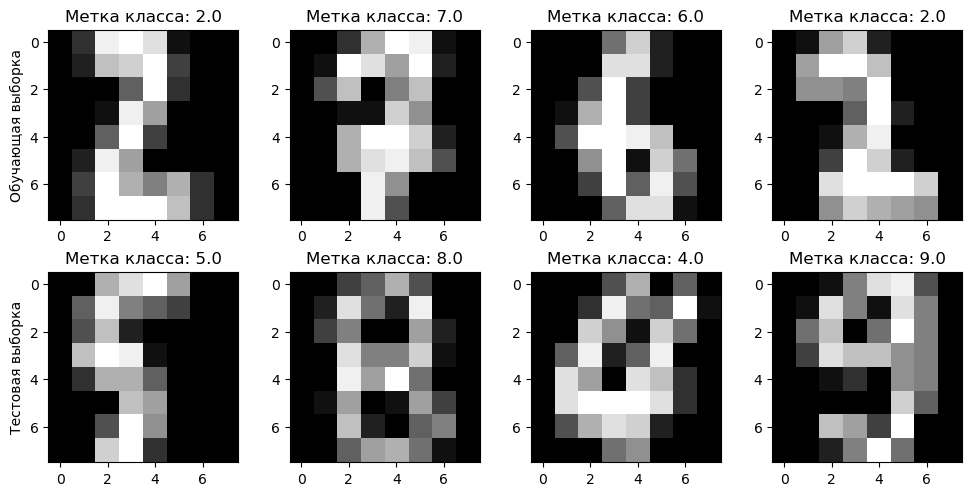

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ds in enumerate(((X_train, y_train), (X_test, y_test))):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds[0]), size=4)):
        image, label = ds[0][kdx], ds[1][kdx]
        axes[idx, jdx].imshow(image.reshape([8, 8]).numpy(), cmap='gray')
        axes[idx, jdx].set_title(f'Метка класса: {label}')
        
axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')

fig.tight_layout()
plt.show()

## Обучение нейронной сети. 

   
Воспользуемся оптимизатором **LBFGS**.

Создадим нейросеть, оптимизатор, а также класс-функцию потерь:

In [21]:
dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size, 
    n_classes=n_classes, n_layers=3, activation=ReLU
)

optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)

loss_fn = CrossEntropyLoss()

In [22]:
dense_network, optimizer, loss_fn

(DenseNetwork(
   (layers): Sequential(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ),
 LBFGS (
 Parameter Group 0
     history_size: 100
     line_search_fn: None
     lr: 1
     max_eval: 1
     max_iter: 1
     tolerance_change: 1e-09
     tolerance_grad: 1e-07
 ),
 CrossEntropyLoss())

In [23]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    
print(type(device), device)

<class 'torch.device'> cuda:0


Для переноса всех параметров модели на нужное устройство можно использовать метод `to`:

In [24]:
dense_network.to(device), next(iter(dense_network.parameters()))

(DenseNetwork(
   (layers): Sequential(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ),
 Parameter containing:
 tensor([[-1.1055e-02, -1.2801e-02, -7.3141e-05,  ..., -1.1406e-02,
          -2.1945e-02, -8.2621e-03],
         [-6.7038e-03,  6.5798e-04, -2.0033e-03,  ...,  1.7620e-02,
           2.6597e-02, -2.8059e-03],
         [-1.0920e-02,  5.5160e-05, -4.8099e-03,  ...,  5.0270e-03,
          -1.1417e-03, -4.1453e-03],
         ...,
         [-9.0527e-03, -1.5621e-02,  1.0084e-02,  ...,  1.4161e-02,
           2.6204e-03,  1.2422e-02],
         [-1.6499e-02,  1.5302e-03, -7.2819e-03,  ..., -1.3066e-02,
           2.1711e-03,  1.7817e-02],
         [ 1.4838e-02, -4.5185e-03,  6.9669e-03,  ..., -7.3850e-03,
          -7.1588e-03, -1.9867e-02]], device='cuda:0', requires_grad=True))

In [25]:
X_train = X_train.to(device)
y_train = y_train.to(device).to(torch.long)
X_test = X_test.to(device)
y_test = y_test.to(device).to(torch.long)

Теперь, осталось только реализовать цикл оптимизации и подсчёт метрик. 

Реализуйте цикл обучения модели в функции `training_loop`:

In [26]:
from typing import Callable, Tuple
import tqdm.notebook as tqdm

def training_loop(n_epochs: int, network: torch.nn.Module, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
                    ds_train: Tuple[torch.Tensor, torch.Tensor], ds_test: Tuple[torch.Tensor, torch.Tensor], device: torch.device,
                    log = False):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.optim.Optimizer optimizer: Оптимизатор
    :param Tuple[torch.Tensor, torch.Tensor] ds_train: Признаки и метки истинного класса обучающей выборки
    :param Tuple[torch.Tensor, torch.Tensor] ds_test: Признаки и метки истинного класса тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True):
        # Переводим сеть в режим обучения
        network.train()

        # Итерация обучения сети
        def closure():
            '''
            Функция-замыкания для подсчёта градиентов функции потерь по обучающей выборке:
                1. Отчистка текущих градиентов
                2. Выполнение прямого прохода по сети в вычисление функции потерь
                3. Вычисление градиентов функции потерь
            :returns: Значение функции потерь
            '''
            optimizer.zero_grad()
            output = network(ds_train[0])
            loss = loss_fn(output, ds_train[1])
            loss.backward()
            return loss
        
        # Шаг оптимизации
        optimizer.step(closure)
        
        # Переводим сеть в инференс режим
        network.eval()

        # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
        #   для ускорения операций
        with torch.no_grad():
            # Вычисление качества и функции потерь на обучающей выборке
            output_train = network(ds_train[0])
            train_loss = loss_fn(output_train, ds_train[1])
            train_acc = (output_train.argmax(dim=1) == ds_train[1]).sum() / len(ds_train[1])
            train_losses.append(train_loss.cpu())
            train_accuracies.append(train_acc.cpu())
            
            # Вычисление качества и функции потерь на тестовой выборке
            output_test = network(ds_test[0])
            test_loss = loss_fn(output_test, ds_test[1])
            test_acc = (output_test.argmax(dim=1) == ds_test[1]).sum() / len(ds_test[1])
            test_losses.append(test_loss.cpu())
            test_accuracies.append(test_acc.cpu())
            
            if epoch % 20 == 0 and log:
                print(
                    'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}'.format(
                        train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                    )
                )
            
    return train_losses, test_losses, train_accuracies, test_accuracies

Обучим сеть. Во всех экспериментах обучайте сеть $200$ эпох с параметром `max_iter=1` в оптимизаторе.

In [27]:
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=200, network=dense_network, loss_fn=loss_fn, 
    optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:

print(f'Cross Entropy (Train/Test): {train_losses[-1]}/{test_losses[-1]}')
print(f'Accuracy (Train/Test): {train_accs[-1]}/{test_accs[-1]}')

Изобразим на графике кривую качества на обучении и контроле по итерациям:

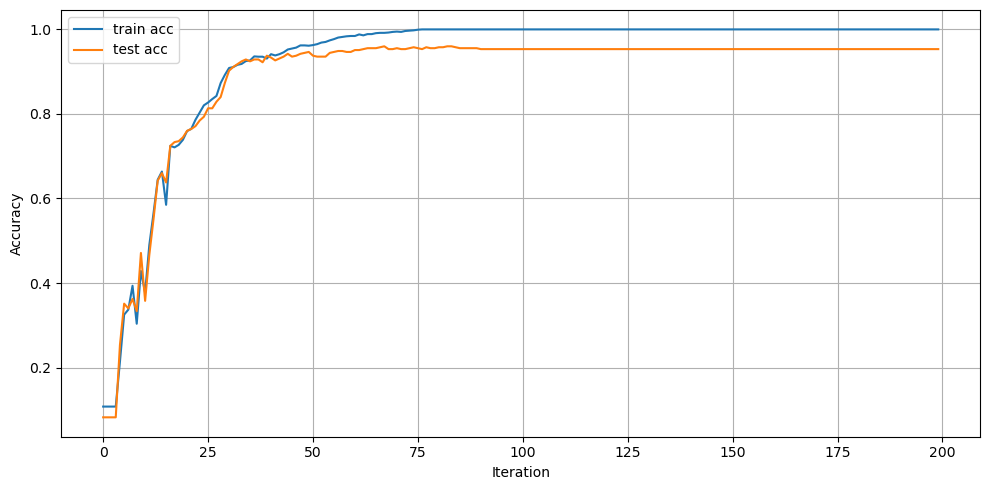

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="train acc")
ax.plot(test_accs, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

## Эксперименты с числом слоев.

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучить нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны, то есть используются одинаковые гиперпараметры обучения).

In [30]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [31]:
from itertools import product

for i, j in tqdm.tqdm(product(range(5), range(5)), total=25):
    dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=i+1, activation=ReLU
    ).to(device)
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()
    
    _, _, train_accs, test_accs = training_loop(
        n_epochs=200, network=dense_network, loss_fn=loss_fn, 
        optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
    )

    accs_train[i, j], accs_test[i, j] = train_accs[-1], test_accs[-1]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

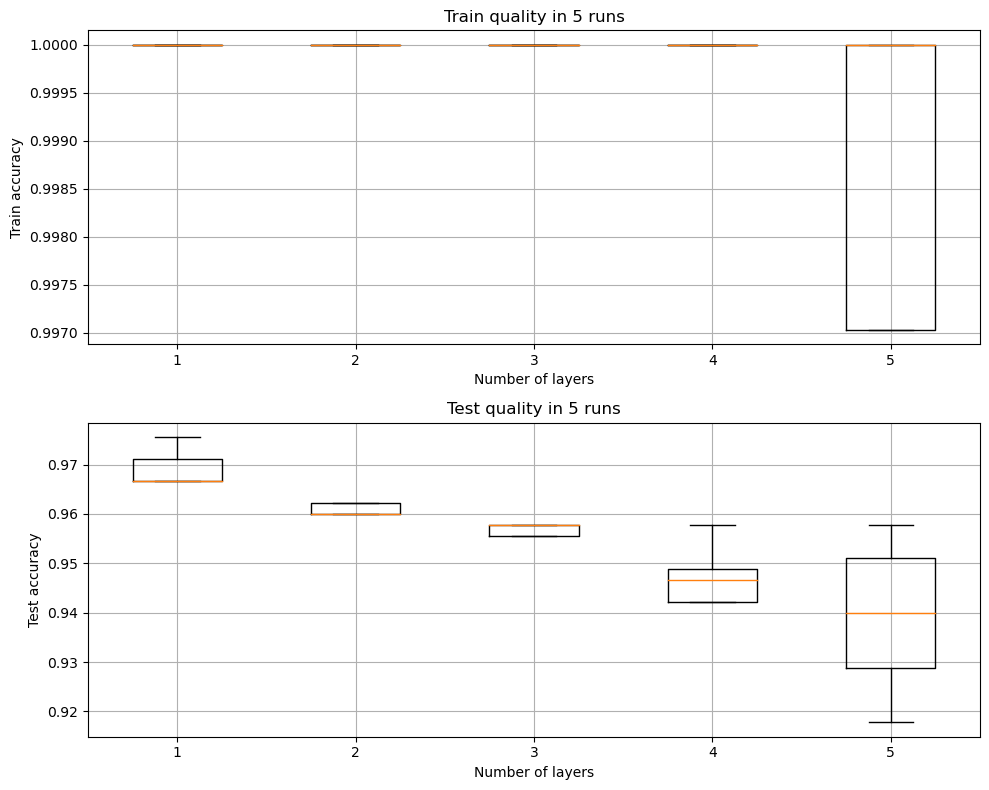

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
1. Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
2. Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?

__Ответы:__ 

1. С ростом количества слоём качество падает, что видно по среднему, устойчивость тоже падает, что видно по возросшему спреду значений. Вероятно это происходит из-за слишком большого количества параметров, которые не успевают обучиться на 200 эпохах.
2. Нет, ибо её достаточно для нашей задачи и она имеет лучшее среднее качество на проведённых тестах.

## Эксперименты c различными инициализациями весов. 

Как уже было сказано, начальная инициализация весов нейронной сети может сильно влиять на процесс ее обучения и, как следствие, на ее качество.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными инициализациями слоев.

Для этого необходимо реализовать функцию, инициализирующую веса линейных слоёв нашей нейронной сети. Для этого воспользуемся методом [`apply`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply), определённым у класса `torch.nn.Module`. Данный метод позволяет рекурсивно применить пользовательскую функцию ко всем подмодулям данного модуля.

Реализуйте функцию `initialize_module`. Добавьте в её функционал возможность инициализировать веса сеть с помощью:
1. **Инициализации Kaiming** (используется, если в нейронной сети в качестве функций активации используется ReLU) 
2. **Инициализации Xavier** (используется, если в нейронной сети в качестве функций активации используется Tanh или Sigmoid)
3. **Инициализации нормальным распределением** с нулевым средним и заданной дисперсией

**Замечание:** метод `apply` применяется рекурсивно ко всем модулям. Чтобы инициализировать линейные слои нужно проверять, является ли данный модуль инстансом класса `Linear`. Можете использовать встроенный метод `isinstance` для такой проверки. 

In [33]:
def initialize_module(module: torch.nn.Module, init: str):
    '''
    Инициализация линейного модуля с заданными параметрами
    :param torch.nn.Module module: Модуль, который нужно инициализировать
    :param Union[str, float] init: В зависимости от значения, выполняется инициализация матрицы весов:
        * init == 'Kaiming': инициализация Kaiming
        * init == 'Xavier': инициализация Xavier
        * isinstance(init, float): инициализация из нормального распределения со стандартным отклонением init
        Вектор смещения всегда инициализируется нулями
        
    '''
    if not isinstance(module, Linear):
        return
    
    torch.nn.init.zeros_(module.bias)

    if init == 'Kaiming':
        torch.nn.init.kaiming_uniform_(module.weight)
    elif init == 'Xavier':
        torch.nn.init.xavier_uniform_(module.weight)
    elif isinstance(init, float):
        torch.nn.init.normal_(module.weight, 0, init)

Теперь попробуем для каждой из $3$ инициализаций обучить нейронную сеть несколько раз. Попробуйте проделать данную операцию при зафиксированном числе слоев равным $3$, $4$ и $5$.

### 3 слоя

Зафиксируем в сети число слоев равное трём.

Заполним матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с инициализацией Kaiming при $i = 3$, с инициализацией Xavier при $i = 4$ и с инициализацией из нормального распределения с фиксированными параметрами при $0 \leqslant i \leqslant 2$ (попробуйте здесь $3$ разных параметра для стандартного отклонения для нормального распределения, например: `1e-3`, `1e-2`, `1e-1`). 

In [34]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [35]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [36]:
from functools import partial

In [37]:
from itertools import product

for i, j in tqdm.tqdm(product(range(5), range(5)), total=25):
    dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=3, activation=ReLU
    ).to(device)
    dense_network.apply(partial(initialize_module, init=init_vars[i]))
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()
    
    _, _, train_accs, test_accs = training_loop(
        n_epochs=200, network=dense_network, loss_fn=loss_fn, 
        optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
    )

    accs_train[i, j], accs_test[i, j] = train_accs[-1], test_accs[-1]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

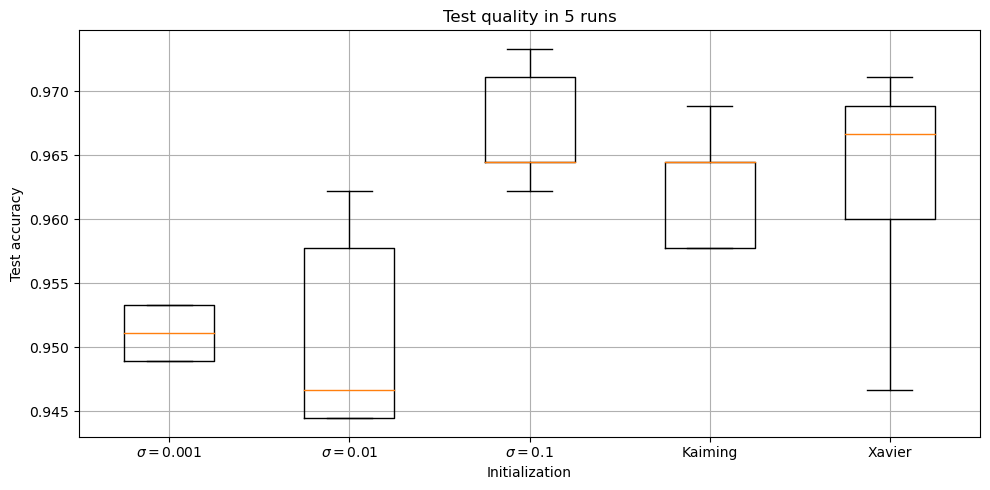

In [38]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

### 4 слоя

Выполните тут тот же код, что и в предыдущем пункте, но только уже с $4$ слоями в сети.

In [39]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [40]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [41]:
for i, j in tqdm.tqdm(product(range(5), range(5)), total=25):
    dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=4, activation=ReLU
    ).to(device)
    dense_network.apply(partial(initialize_module, init=init_vars[i]))
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()
    
    _, _, train_accs, test_accs = training_loop(
        n_epochs=200, network=dense_network, loss_fn=loss_fn, 
        optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
    )

    accs_train[i, j], accs_test[i, j] = train_accs[-1], test_accs[-1]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

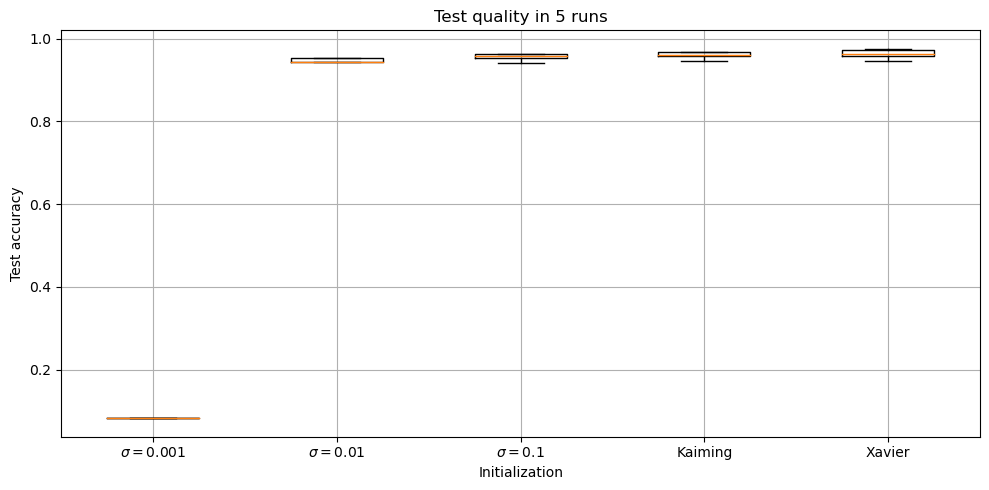

In [42]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

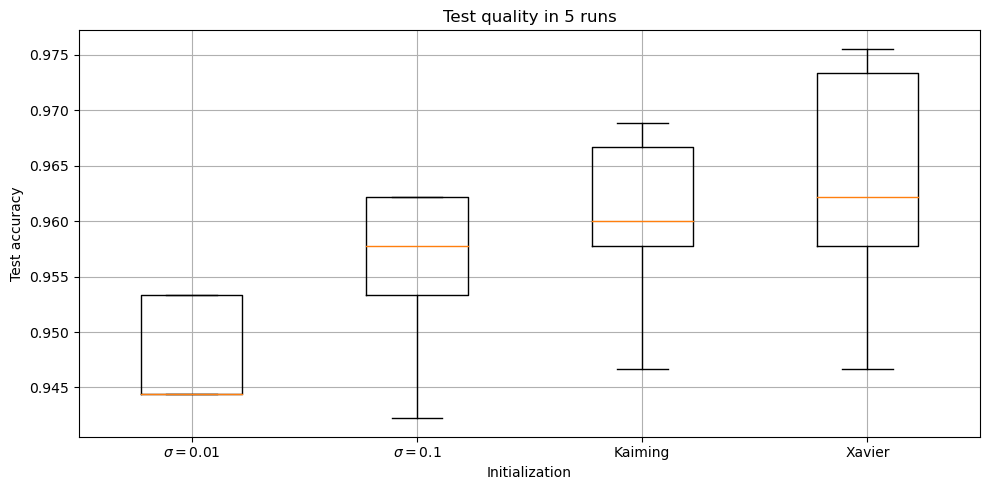

In [43]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T[:,1:], labels=init_vars_for_plot[1:], showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

### 5 слоев

Выполним код, что и в предыдущем пункте, но только уже с $5$ слоями в сети.

In [44]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [45]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [46]:
for i, j in tqdm.tqdm(product(range(5), range(5)), total=25):
    dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=5, activation=ReLU
    ).to(device)
    dense_network.apply(partial(initialize_module, init=init_vars[i]))
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()
    
    _, _, train_accs, test_accs = training_loop(
        n_epochs=200, network=dense_network, loss_fn=loss_fn, 
        optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
    )

    accs_train[i, j], accs_test[i, j] = train_accs[-1], test_accs[-1]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

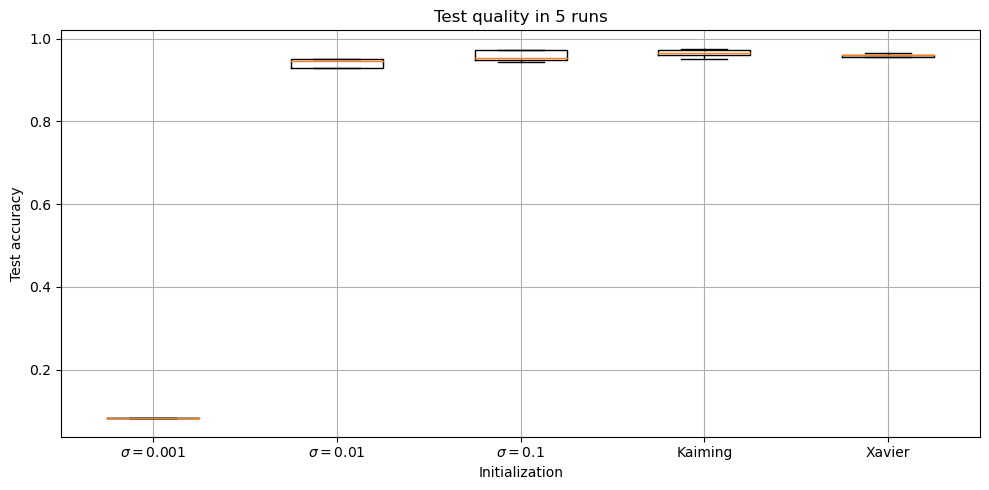

In [47]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

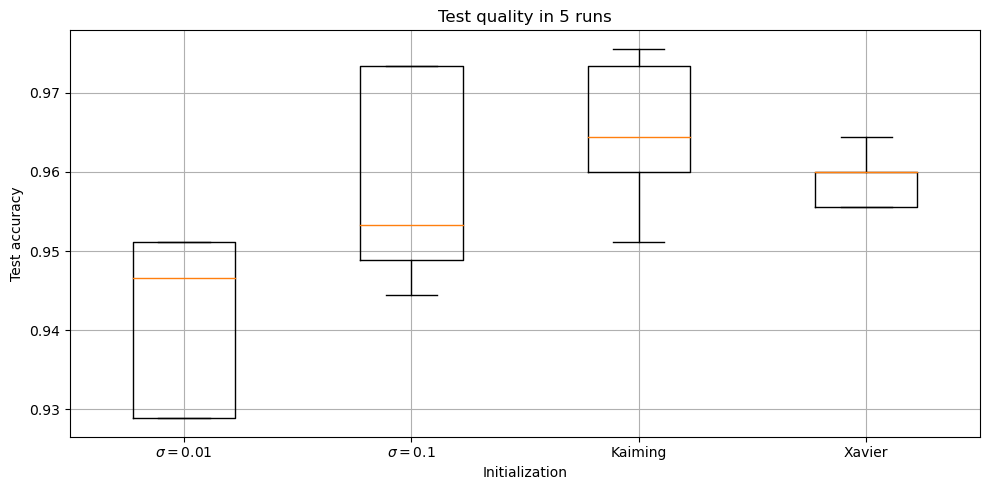

In [48]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T[:,1:], labels=init_vars_for_plot[1:], showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются на контроле качество и устойчивость процесса обучения при различных инициализациях?
* Какие инициализации помогают обучать более глубокие сети?

__Ответы:__

1. Все варианты имеют примерно одинаковую устойчивость, но по качеству располагаются в порядке `Xavier, Kaiming, `$\sigma$ `= 0.1, `$\sigma$ `= 0.01, `$\sigma$ `= 0.001` в сетях более чем с тремя слоями.
2. Все инициализации кроме варианта $\sigma$ `= 0.001` подходят для обучения глубоких сетей, судя по сохраняющемуся примерно на одном месте среднему.

Теперь сравним скорость обучения при различных инициализациях. Создайте два списка списков `accs_test_on_iterations`, `accs_train_on_iterations` в каждом из которых в позиции `[i]` (см. описание `i` в предыдущем пункте) будет лежать список из значений `accuracy` на тестовой и обучающей выборках соответственно, полученных во время обучения модели. Количество слоев в сети зафиксируйте равным 4.

In [49]:
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [50]:
accs_test_on_iterations = []
accs_train_on_iterations = []

for i in range(5):
    dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=4, activation=ReLU
    ).to(device)
    dense_network.apply(partial(initialize_module, init=init_vars[i]))
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()
    
    _, _, train_accs, test_accs = training_loop(
        n_epochs=200, network=dense_network, loss_fn=loss_fn, 
        optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
    )

    accs_test_on_iterations.append(test_accs)
    accs_train_on_iterations.append(train_accs)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

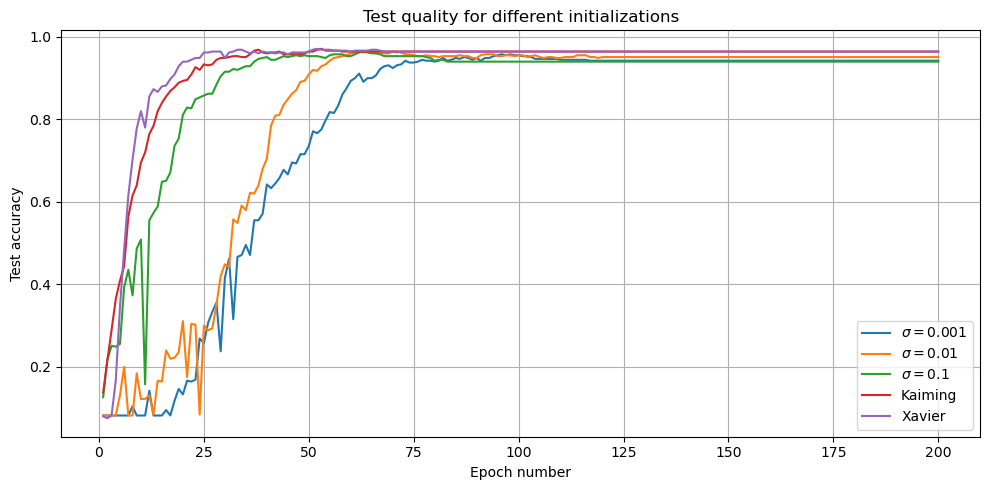

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, label in enumerate(init_vars_for_plot):
    ax.plot(range(1, 201), accs_test_on_iterations[idx], label=label)

ax.set_title("Test quality for different initializations")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Test accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как меняется скорость обучения в зависимости от выбранной инициализации?

__Ответы:__

* Три лучших по точности варианта из предыдущих экспериментов имеют примерно одинаковую наилучшую скорость обучения, что ожидаемо, оставшиеся варианты располагаются так же как и в прошлом эксперименте - вариант $\sigma = 0.001$ занимает последнее место.

## Эксперименты c различными функциями активации. [Кросспроверка. 2 балла]

Проверим теперь, с какой функцией активации нейронная сеть будет обучаться лучше.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными функциями активации.

Для этого нам нужно реализовать еще $2$ слоя: для функций активации `Tanh` и `Sigmoid`.

In [52]:
class Tanh(torch.nn.Module):
    def __init__(self):
        """
        tanh(y) = (e^y - e^(-y)) / (e^y + e^(-y))
        Используйте функцию torch.tanh для подсчета гиперболического тангенса.
        Вы можете сами реализовать подсчет tanh, но тогда вам нужно устойчиво его вычислять.
        """
        super().__init__()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Поэлементное применение Tanh
        """
        return torch.tanh(x)

    def __repr__(self):
        return 'Tanh()'

In [53]:
class Sigmoid(torch.nn.Module):
    def __init__(self):
        """
        sigmoid(y) = 1 / (1 + e^(-y))
        Используйте функцию torch.special.expit для подсчета сигмоиды.
        Вы можете сами реализовать подсчет сигмоиды, но тогда вам нужно устойчиво ее вычислять.
        """
        super().__init__()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Поэлементное применение Sigmoid
        """
        return torch.sigmoid(x)

    def __repr__(self):
        return 'Sigmoid()'

Теперь попробуем для каждой из 3 функций активации обучить нейронную сеть несколько раз. Число слоев зафиксируйте равным $3$. В случае `Tanh` и `Sigmoid` используйте инициализацию `Xavier`, а в случае `ReLU` используйте инициализацию `Kaiming`.

Заполним матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с функцией активации $ReLU$ при $i = 0$, с функцией активации $Tanh$ при $i = 1$ и с функцией активации $Sigmoid$ при $i = 2$.

In [54]:
act_func_vars = [ReLU, Tanh, Sigmoid]
init_for_act_funcs = ['Kaiming', 'Xavier', 'Xavier']

In [55]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))

In [56]:
for i, j in tqdm.tqdm(product(range(3), range(5)), total=3 * 5):
    dense_network = DenseNetwork(
        in_features=in_features, hidden_size=hidden_size, 
        n_classes=n_classes, n_layers=3, activation=act_func_vars[i]
    ).to(device)
    dense_network.apply(partial(initialize_module, init=init_for_act_funcs[i]))
    optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
    loss_fn = CrossEntropyLoss()
    
    _, _, train_accs, test_accs = training_loop(
        n_epochs=200, network=dense_network, loss_fn=loss_fn, 
        optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
    )

    accs_test[i, j] = test_accs[-1]
    accs_train[i, j] = train_accs[-1]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

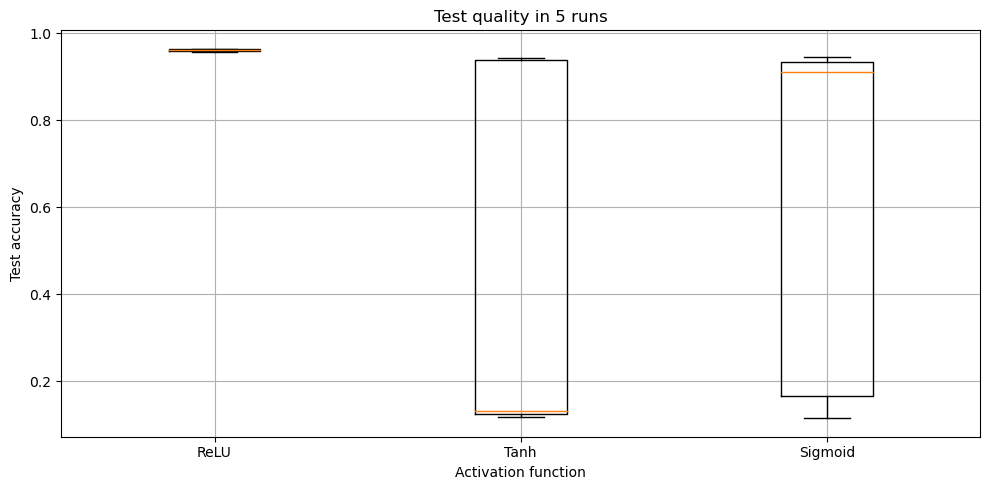

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=[i.__name__ for i in act_func_vars], showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Activation function")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()